## Classifying programming language 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [35]:
pd.options.display.max_columns = None

### Data cleaning and modeling

In [36]:
df = pd.read_csv('./data.csv',encoding='utf-8')

In [37]:
df.head(10)

,language,proj_id,file_id,file_body
0,JavaScript,10001,100001,// Functions as values of a variable\nvar cube...
1,JavaScript,10001,100002,// Functions as values of a variable\nvar cube...
2,JavaScript,10002,100003,function median(ary) {\n if (ary.length == ...
3,JavaScript,10002,100004,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n"
4,JavaScript,10002,100005,(() => {\n 'use strict';\n\n // median :...
5,JavaScript,10003,100006,"function divByZero(dividend,divisor)\n{\n\tvar..."
6,JavaScript,10004,100007,"if (""abs"" in Math) { ... }\n"
7,JavaScript,10004,100008,"if (typeof bloop !== ""undefined"") { ... }\n"
8,JavaScript,10005,100009,(function () {\n 'use strict';\n\n // di...
9,JavaScript,10005,100010,"function sort_disjoint(values, indices) {\n v..."


Joining rows from file_body column with the same project_id. 

In [38]:
df.file_body = df.file_body.astype(str)

In [39]:
data = df.groupby(['language', 'proj_id'])['file_body'].apply(lambda x: ' '.join(x)).reset_index()

Data cleaning and checking for nans, nulls duplicated rows etc.

In [40]:
data.isnull().sum()

language     0
proj_id      0
file_body    0
dtype: int64

In [41]:
data.isna().sum()

language     0
proj_id      0
file_body    0
dtype: int64

In [42]:
data.duplicated('file_body').value_counts()

False    10001
True         8
dtype: int64

In [43]:
data.drop_duplicates('file_body',keep='first',inplace=True)

In [44]:
len(data)

10001

Changing any number to 'numb' string and ridding of new line marks.

In [45]:
data.file_body = data.file_body.str.replace(r'\d+(\.\d+)?','numb')
data = data.replace('\n','', regex=True)

In [46]:
data = data[data.file_body != 'numb']

Plotting percentage sizes of separate programing languages in dataset.

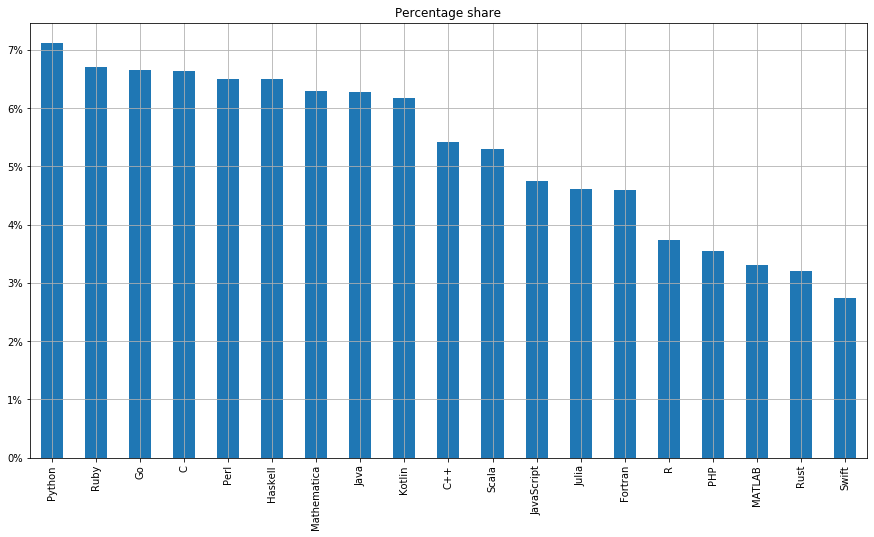

In [47]:
var = data.language.value_counts()/len(data)
fig = plt.figure(figsize=(15,8))
ax = var.plot(kind='bar',grid=True)
ax.set_title ("Percentage share")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

Plotting vecorized parts of programming languages to seek for any pattern etc also labeling programming languages names for faster modeling perforamnce.

In [48]:
le_makename = LabelEncoder()
data['language_enc'] = le_makename.fit_transform(data.language)

In [49]:
X = data.file_body

pipeline = Pipeline([
    ('vect', CountVectorizer(token_pattern=r'[a-zA-Z]{2,}|\s|[^\w\d\s]+')),
    ('tfidf', TfidfTransformer()),
])        
X_ = pipeline.fit_transform(X).todense()

pca = PCA(n_components=19).fit(X_)
data2D = pca.transform(X_)

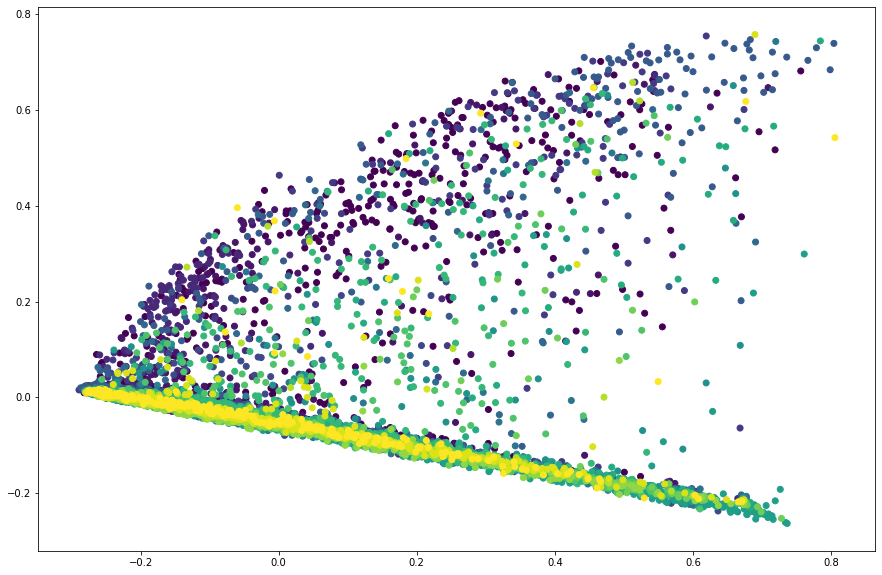

In [50]:
plt.figure(figsize=(15,10))
plt.scatter(data2D[:,0], data2D[:,1],c=data.language_enc)

## Modeling

Splitting data and defining models on default parameters to see which is the best.

In [51]:
X = data.file_body
Y = data.language_enc

In [52]:
vectorizer = CountVectorizer(token_pattern=r'[a-zA-Z]{2,}|\s|[^\w\d\s]+')
Xcounts = vectorizer.fit_transform(X.values.astype('U'))

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(Xcounts, Y,test_size=0.2, random_state=0)

In [54]:
names = ["SVM Linear",
        "Naive Bayes",
        "SGD Classifier",
        "K-nearest Neighbors",
        "Decision Tree", 
        "Random Forest",
        "XGBoost"
        ]

classifiers = [
        SVC(kernel = 'linear'),
        MultinomialNB(),
        SGDClassifier(max_iter = 100),
        KNeighborsClassifier(), #Adding K-n for curiosty but from the last plot above in my opinion this classifier will has the more struggles than the rest
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        XGBClassifier()    
   
]

models = zip(names, classifiers)
Mods = []

for name, model in models:
    model.fit(X_train,Y_train)
    accuracy = model.score(X_test, Y_test)*100
    Mods.append(accuracy)
    print("{} Accuracy: {}".format(name, accuracy))

SVM Linear Accuracy: 86.3568215892054
Naive Bayes Accuracy: 84.70764617691154
SGD Classifier Accuracy: 84.50774612693654
K-nearest Neighbors Accuracy: 44.97751124437781
Decision Tree Accuracy: 85.70714642678661
Random Forest Accuracy: 95.3023488255872
XGBoost Accuracy: 95.25237381309346


In [55]:
d = {"Model":names,'Accuracy':Mods}
df = pd.DataFrame(d)
df.sort_values('Accuracy',ascending=False)

,Model,Accuracy
5,Random Forest,95.302349
6,XGBoost,95.252374
0,SVM Linear,86.356822
4,Decision Tree,85.707146
1,Naive Bayes,84.707646
2,SGD Classifier,84.507746
3,K-nearest Neighbors,44.977511


Making Voting Classifier which includes two best performing models.

In [56]:
from sklearn.ensemble import VotingClassifier

names = ["Random Forest",
        "XGBoost",
        ]

classifiers = [
    RandomForestClassifier(),
    XGBClassifier()    
]

models = list(zip(names, classifiers))

ensemble = VotingClassifier(estimators = models, voting = 'hard', n_jobs = -1)
ensemble.fit(X_train, Y_train)
accuracy = ensemble.score(X_test, Y_test)*100
print("Voting Classifier: Accuracy: {}".format(accuracy))

Voting Classifier: Accuracy: 95.00249875062468


As it shown above this ensamble model dosen't perform better than Random Forest classifier alone. 
So now I will look at the details of outcomes for best classifier.

In [57]:
classes = data.language.unique()
classes.sort()

In [58]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, Y_train)
y_predicted = rf_clf.predict(X_test)

              precision    recall  f1-score   support

           C       0.98      0.96      0.97       134
         C++       0.97      0.97      0.97        90
     Fortran       1.00      0.96      0.98        89
          Go       0.99      0.98      0.98       131
     Haskell       0.97      0.98      0.97       133
        Java       0.98      0.95      0.97       108
  JavaScript       0.98      0.96      0.97       112
       Julia       0.83      0.89      0.86        93
      Kotlin       1.00      0.98      0.99       124
      MATLAB       0.87      0.91      0.89        66
 Mathematica       0.93      1.00      0.97       129
         PHP       0.96      0.96      0.96        67
        Perl       0.96      0.96      0.96       141
      Python       0.94      0.98      0.96       133
           R       0.84      0.93      0.88        83
        Ruby       0.97      0.94      0.96       144
        Rust       1.00      0.95      0.97        57
       Scala       0.98    

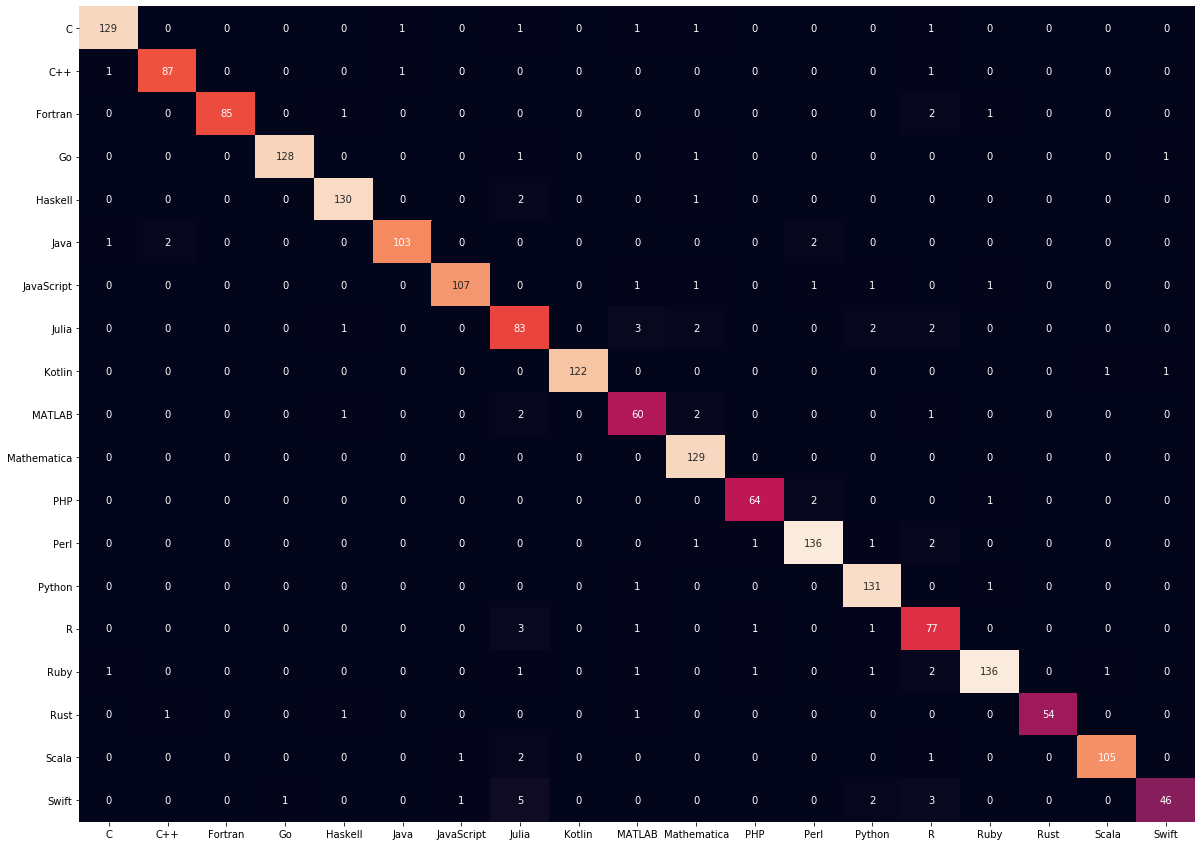

In [59]:
print(classification_report(Y_test,y_predicted,target_names=list(classes)))
fig = plt.figure(figsize=(20,15))
ax = sns.heatmap(confusion_matrix(Y_test,y_predicted),annot=True,fmt='.0f',cbar=False,xticklabels=classes,yticklabels=classes)

As we can see from the classification report and heat map our Random Forest classifier has the lowest outcomes for Swift and Julia.

In [60]:
from sklearn.model_selection import RandomizedSearchCV

In [61]:
n_estimators = list(range(100,111))
max_features = list(range(1,12))

In [62]:
rf = RandomForestClassifier()

In [63]:
hyperF = dict(n_estimators = n_estimators, 
              max_features=max_features)

In [64]:
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = hyperF, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

In [65]:
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [66]:
rf_random.best_params_

{'n_estimators': 103, 'max_features': 11}

In [67]:
y_preds = rf_random.predict(X_test)
print(accuracy_score(Y_test, y_preds))

0.9365317341329336


# Summary

According to the results Random Forest model without setting any parameters has the best results so far. Accuracy, recall, precision are around 95-96% so there is a little space for a random search for tunning a model but more useful approch will be to enlarge dataset for learning or investigate the cases in which model had problem to classify. 